In [2]:
from google.colab import drive
drive.mount('/content/drive')

# Verify dataset exists
import os
print("\nChecking dataset...")
data_path = '/content/drive/MyDrive/data'
if os.path.exists(data_path):
    print(f"✓ Dataset found at {data_path}")
    print(f"✓ Train folder: {os.path.exists(os.path.join(data_path, 'train'))}")
    print(f"✓ Val folder: {os.path.exists(os.path.join(data_path, 'val'))}")
else:
    print(f"✗ Dataset not found at {data_path}")
    print("Please check the path or upload the 'data' folder to Google Drive")

# Install and import dependencies
!pip install -q tensorflow matplotlib seaborn scikit-learn

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

print(f"\nTensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Checking dataset...
✓ Dataset found at /content/drive/MyDrive/data
✓ Train folder: True
✓ Val folder: True

TensorFlow version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
TRAIN_DIR = '/content/drive/MyDrive/data/train'
VAL_DIR = '/content/drive/MyDrive/data/val'

# Hyperparameters optimized for T4 GPU
IMG_SIZE = 128
BATCH_SIZE = 64  # Increased for T4 GPU (faster training)
EPOCHS = 50
LEARNING_RATE = 0.0001

# Enable mixed precision for faster training on T4
from tensorflow.keras import mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)
print(f'Compute dtype: {policy.compute_dtype}')
print(f'Variable dtype: {policy.variable_dtype}')

Compute dtype: float16
Variable dtype: float32


In [4]:
# ============================================================================
# CELL 3 ALTERNATIVE: Better Data Loading
# ============================================================================
import tensorflow as tf

# Create datasets from directory
train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    labels='inferred',
    label_mode='binary',
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    shuffle=True,
    seed=42
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    VAL_DIR,
    labels='inferred',
    label_mode='binary',
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    shuffle=True,
    seed=42
)

# Apply augmentation to training data
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

# Normalize
normalization_layer = tf.keras.layers.Rescaling(1./255)

def prepare_train(ds):
    ds = ds.map(lambda x, y: (data_augmentation(x), y))
    ds = ds.map(lambda x, y: (normalization_layer(x), y))
    return ds.prefetch(buffer_size=tf.data.AUTOTUNE)

def prepare_val(ds):
    ds = ds.map(lambda x, y: (normalization_layer(x), y))
    return ds.prefetch(buffer_size=tf.data.AUTOTUNE)

train_ds = prepare_train(train_ds)
val_ds = prepare_val(val_ds)

print(f"Training batches: {tf.data.experimental.cardinality(train_ds).numpy()}")
print(f"Validation batches: {tf.data.experimental.cardinality(val_ds).numpy()}")

Found 8878 files belonging to 2 classes.
Found 600 files belonging to 2 classes.
Training batches: 139
Validation batches: 10


In [5]:
def build_fracture_detection_model(input_shape=(IMG_SIZE, IMG_SIZE, 1)):
    model = models.Sequential([
        # Input layer
        layers.Input(shape=input_shape),

        # Block 1
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Block 2
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Block 3
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.4),

        # Dense layers
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid', dtype='float32')  # Force float32 for output
    ])

    return model

# Create and compile model
model = build_fracture_detection_model()
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='binary_crossentropy',
    metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()]
)

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 8,711,137 (33.23 MB)

 Trainable params: 8,709,729 (33.22 MB)

 Non-trainable params: 1,408 (5.50 KB)

In [6]:
callbacks = [
    # Early stopping to prevent overfitting
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),

    # Reduce learning rate when validation loss plateaus
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),

    # Save best model
    ModelCheckpoint(
        'best_fracture_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

In [7]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.5442 - loss: 1.0636 - precision: 0.5504 - recall: 0.3901
Epoch 1: val_accuracy improved from -inf to 0.40000, saving model to best_fracture_model.h5


139/139 ━━━━━━━━━━━━━━━━━━━━ 1380s 10s/step - accuracy: 0.5444 - loss: 1.0628 - precision: 0.5507 - recall: 0.3907 - val_accuracy: 0.4000 - val_loss: 1.8719 - val_precision: 0.4000 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 2/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.6104 - loss: 0.8056 - precision: 0.6072 - recall: 0.5833
Epoch 2: val_accuracy did not improve from 0.40000
139/139 ━━━━━━━━━━━━━━━━━━━━ 40s 280ms/step - accuracy: 0.6105 - loss: 0.8055 - precision: 0.6073 - recall: 0.5834 - val_accuracy: 0.4000 - val_loss: 1.5936 - val_precision: 0.4000 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 3/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - accuracy: 0.6438 - loss: 0.7231 - precision: 0.6433 - recall: 0.6308
Epoch 3: val_accuracy improved from 0.40000 to 0.74667, saving model to best_fracture_model.h5


139/139 ━━━━━━━━━━━━━━━━━━━━ 40s 284ms/step - accuracy: 0.6438 - loss: 0.7230 - precision: 0.6433 - recall: 0.6308 - val_accuracy: 0.7467 - val_loss: 0.5519 - val_precision: 0.7619 - val_recall: 0.5333 - learning_rate: 1.0000e-04
Epoch 4/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - accuracy: 0.6833 - loss: 0.6373 - precision: 0.6805 - recall: 0.6734
Epoch 4: val_accuracy did not improve from 0.74667
139/139 ━━━━━━━━━━━━━━━━━━━━ 39s 277ms/step - accuracy: 0.6834 - loss: 0.6371 - precision: 0.6805 - recall: 0.6735 - val_accuracy: 0.5333 - val_loss: 0.9376 - val_precision: 0.4615 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 5/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - accuracy: 0.7196 - loss: 0.5660 - precision: 0.7105 - recall: 0.7266
Epoch 5: val_accuracy did not improve from 0.74667
139/139 ━━━━━━━━━━━━━━━━━━━━ 41s 294ms/step - accuracy: 0.7197 - loss: 0.5659 - precision: 0.7106 - recall: 0.7266 - val_accuracy: 0.5417 - val_loss: 0.8349 - val_precision: 0.4619 - val_r

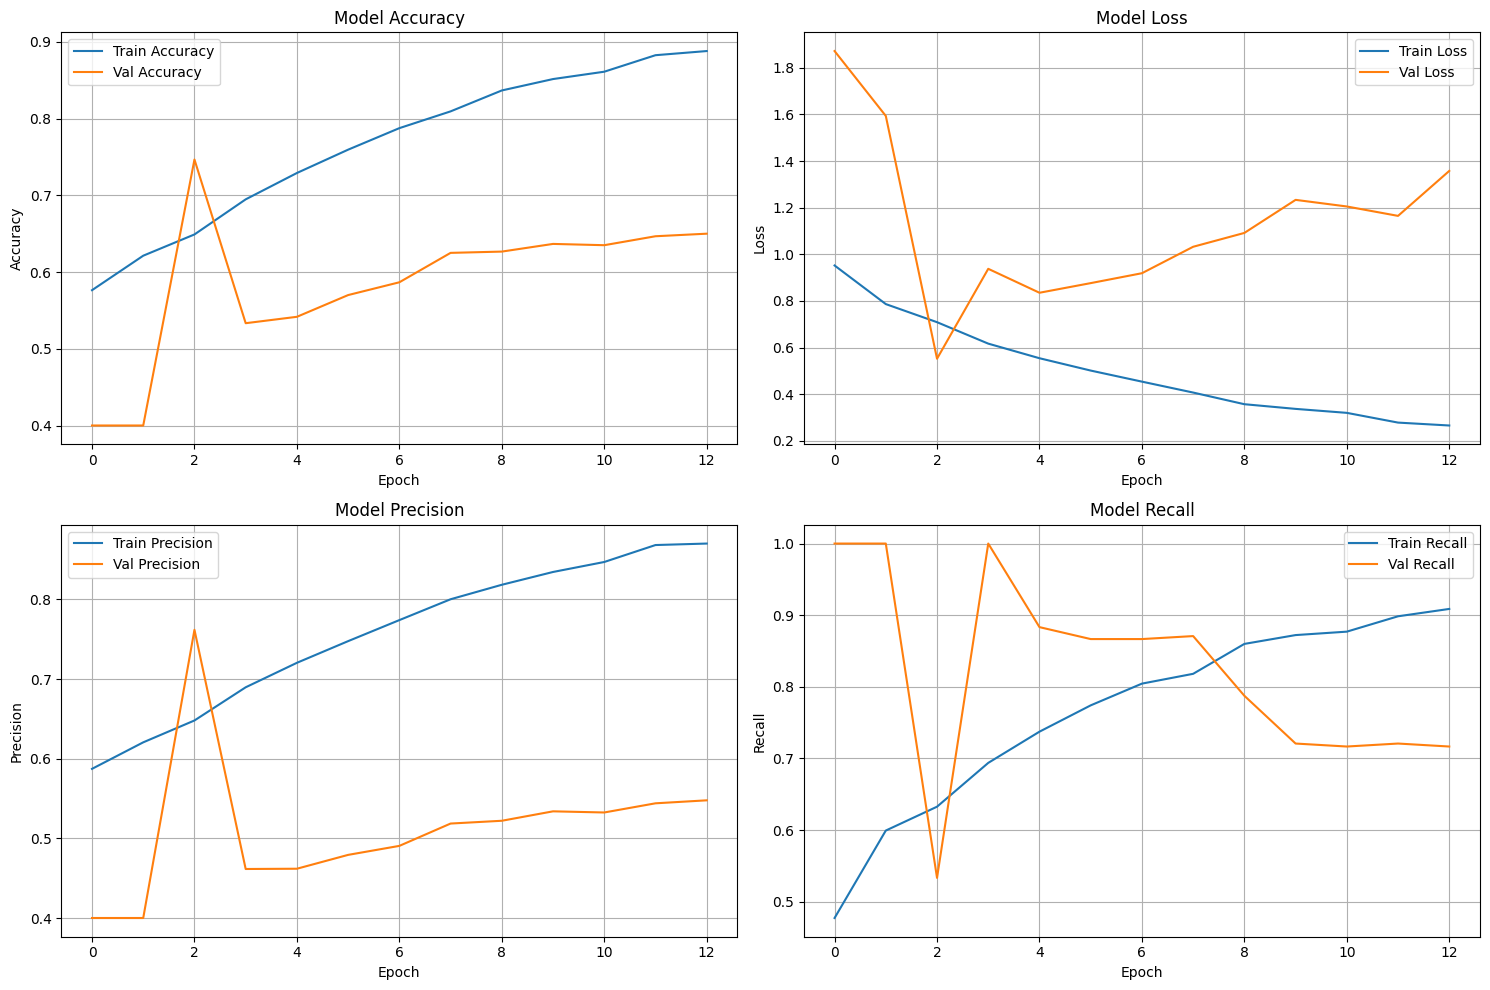

In [12]:
# ============================================================================
# CELL 7: Plot Training History
# ============================================================================
def plot_training_history(history):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Accuracy
    axes[0, 0].plot(history.history['accuracy'], label='Train Accuracy')
    axes[0, 0].plot(history.history['val_accuracy'], label='Val Accuracy')
    axes[0, 0].set_title('Model Accuracy')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].legend()
    axes[0, 0].grid(True)

    # Loss
    axes[0, 1].plot(history.history['loss'], label='Train Loss')
    axes[0, 1].plot(history.history['val_loss'], label='Val Loss')
    axes[0, 1].set_title('Model Loss')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True)

    # Precision
    axes[1, 0].plot(history.history['precision'], label='Train Precision')
    axes[1, 0].plot(history.history['val_precision'], label='Val Precision')
    axes[1, 0].set_title('Model Precision')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Precision')
    axes[1, 0].legend()
    axes[1, 0].grid(True)

    # Recall
    axes[1, 1].plot(history.history['recall'], label='Train Recall')
    axes[1, 1].plot(history.history['val_recall'], label='Val Recall')
    axes[1, 1].set_title('Model Recall')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Recall')
    axes[1, 1].legend()
    axes[1, 1].grid(True)

    plt.tight_layout()
    plt.show()

plot_training_history(history)

In [13]:
# ============================================================================
# CELL 8: Evaluate Model
# ============================================================================
# Evaluate on validation set
val_loss, val_accuracy, val_precision, val_recall = model.evaluate(val_ds)
print(f"\nValidation Results:")
print(f"Loss: {val_loss:.4f}")
print(f"Accuracy: {val_accuracy:.4f}")
print(f"Precision: {val_precision:.4f}")
print(f"Recall: {val_recall:.4f}")
print(f"F1-Score: {2 * (val_precision * val_recall) / (val_precision + val_recall):.4f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 190ms/step - accuracy: 0.7269 - loss: 0.5767 - precision: 0.7522 - recall: 0.5008

Validation Results:
Loss: 0.5519
Accuracy: 0.7467
Precision: 0.7619
Recall: 0.5333
F1-Score: 0.6275



Classification Report:
               precision    recall  f1-score   support

    Fractured       0.74      0.89      0.81       360
Not Fractured       0.76      0.53      0.63       240

     accuracy                           0.75       600
    macro avg       0.75      0.71      0.72       600
 weighted avg       0.75      0.75      0.74       600



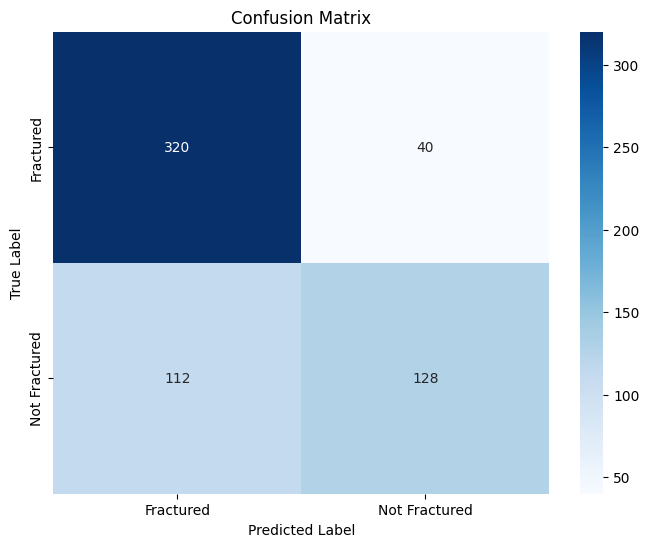

In [14]:
# ============================================================================
# CELL 9: Generate Predictions and Confusion Matrix
# ============================================================================
# Collect all predictions
all_predictions = []
all_labels = []

for images, labels in val_ds:
    preds = model.predict(images, verbose=0)
    all_predictions.extend(preds.flatten())
    all_labels.extend(labels.numpy())

all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)

# Convert to class predictions
predicted_classes = (all_predictions > 0.5).astype(int)
true_classes = all_labels.astype(int)

# Classification report
print("\nClassification Report:")
print(classification_report(true_classes, predicted_classes,
                          target_names=['Fractured', 'Not Fractured']))

# Confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Fractured', 'Not Fractured'],
            yticklabels=['Fractured', 'Not Fractured'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [15]:
# ============================================================================
# CELL 10: Save Model to Google Drive
# ============================================================================
# Save to Google Drive for permanent storage
model.save('/content/drive/MyDrive/fracture_detection_final.h5')
print("✅ Model saved to Google Drive: fracture_detection_final.h5")

# Also save as Keras format
model.save('/content/drive/MyDrive/fracture_detection_final.keras')
print("✅ Model saved to Google Drive: fracture_detection_final.keras")

✅ Model saved to Google Drive: fracture_detection_final.h5
✅ Model saved to Google Drive: fracture_detection_final.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


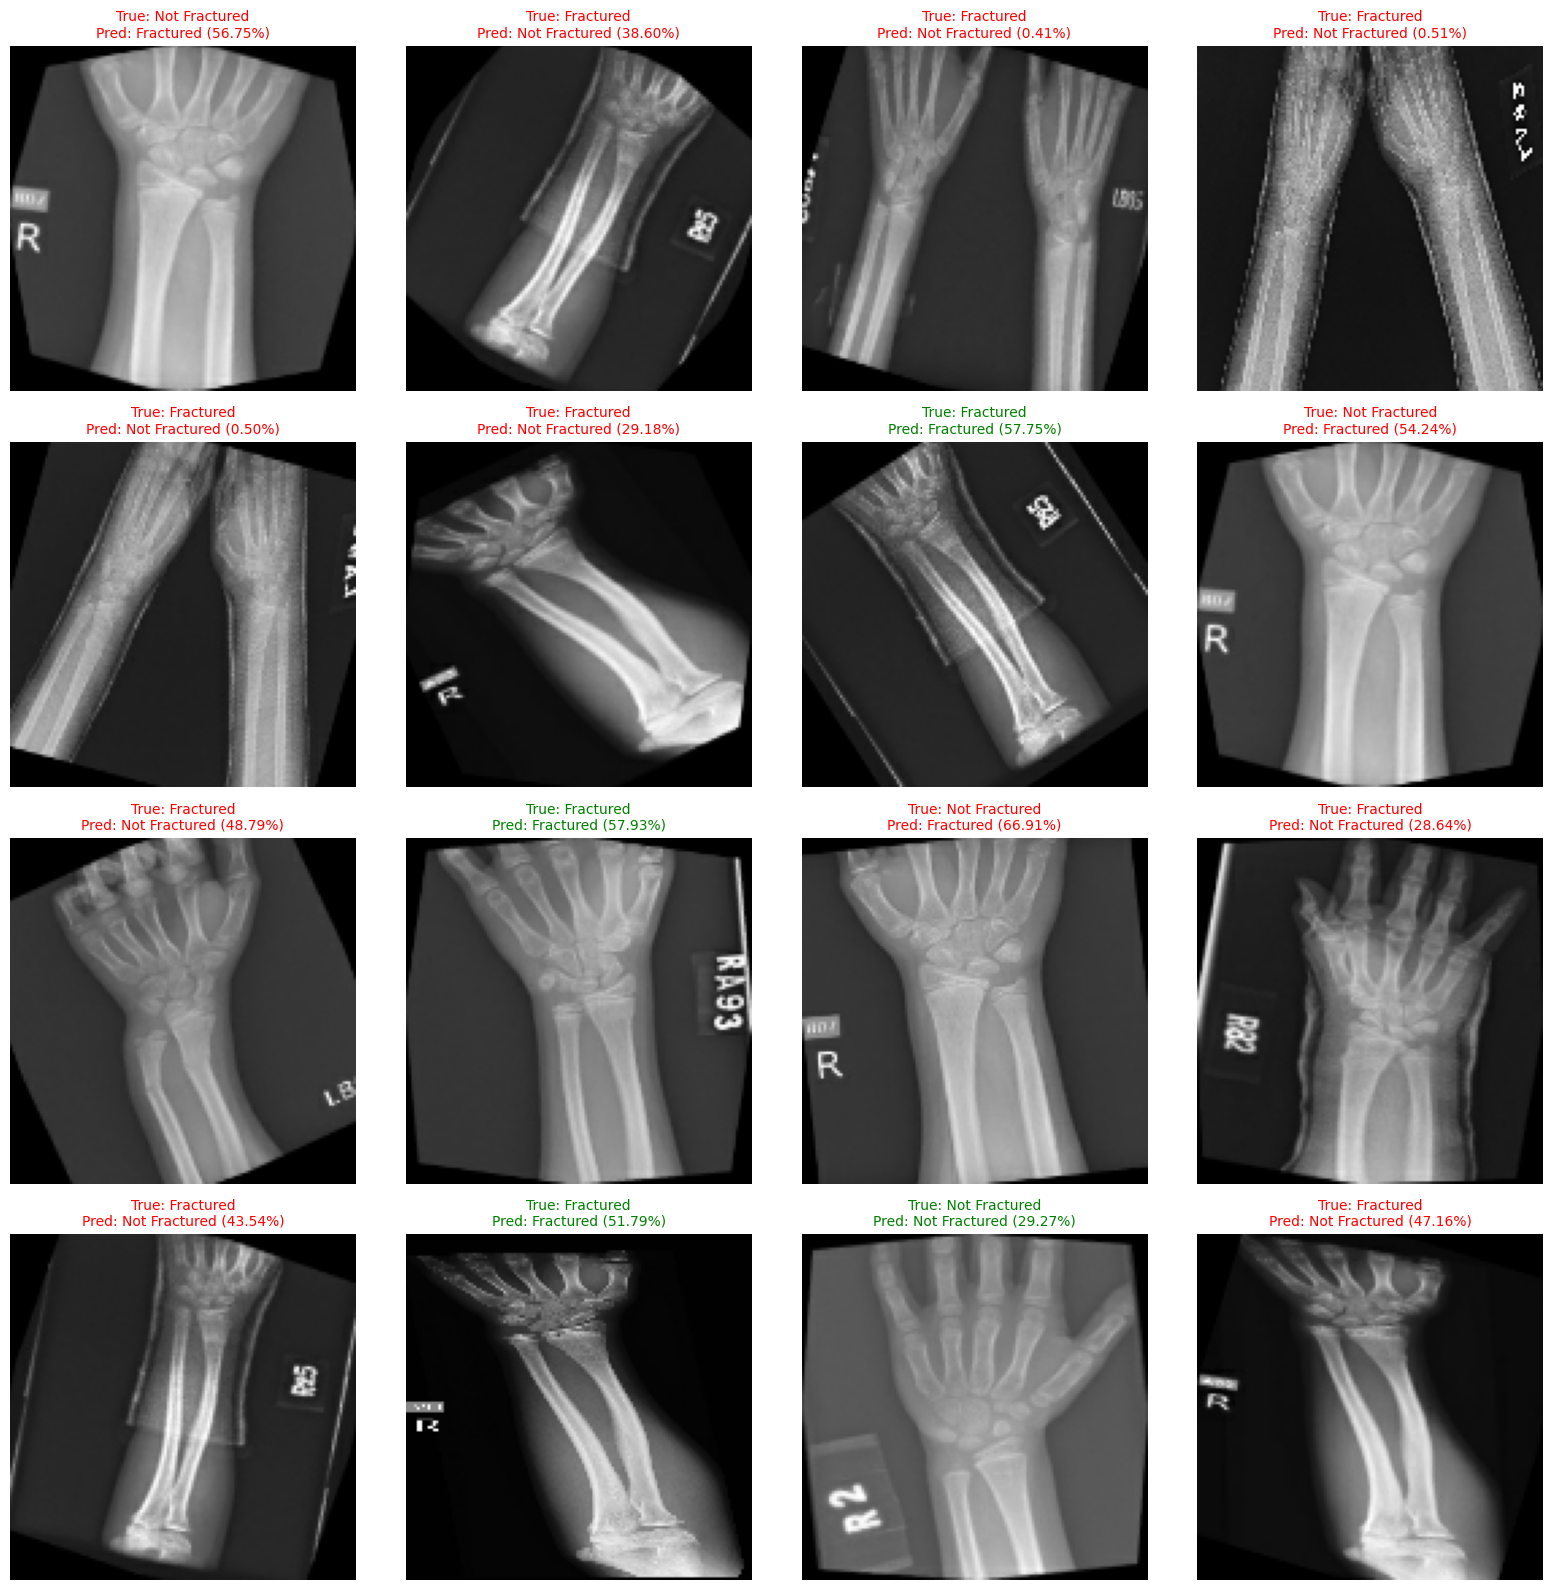

In [16]:
# ============================================================================
# CELL 10: Visualize Sample Predictions
# ============================================================================
import matplotlib.pyplot as plt
import numpy as np

# Get a batch of validation data
val_batch_iter = iter(val_ds)
val_images, val_labels = next(val_batch_iter)

# Make predictions
predictions = model.predict(val_images[:16])

# Plot
fig, axes = plt.subplots(4, 4, figsize=(16, 16))
for i, ax in enumerate(axes.flat):
    if i < len(val_images):
        # Display image
        img = val_images[i].numpy().squeeze()
        ax.imshow(img, cmap='gray')

        # Get prediction
        pred_prob = predictions[i][0]
        pred_class = 'Fractured' if pred_prob > 0.5 else 'Not Fractured'
        true_class = 'Fractured' if val_labels[i] == 0 else 'Not Fractured'

        # Color: green if correct, red if wrong
        color = 'green' if (pred_prob > 0.5) == (val_labels[i] == 0) else 'red'

        ax.set_title(f'True: {true_class}\nPred: {pred_class} ({pred_prob:.2%})',
                     color=color, fontsize=10)
        ax.axis('off')

plt.tight_layout()
plt.show()

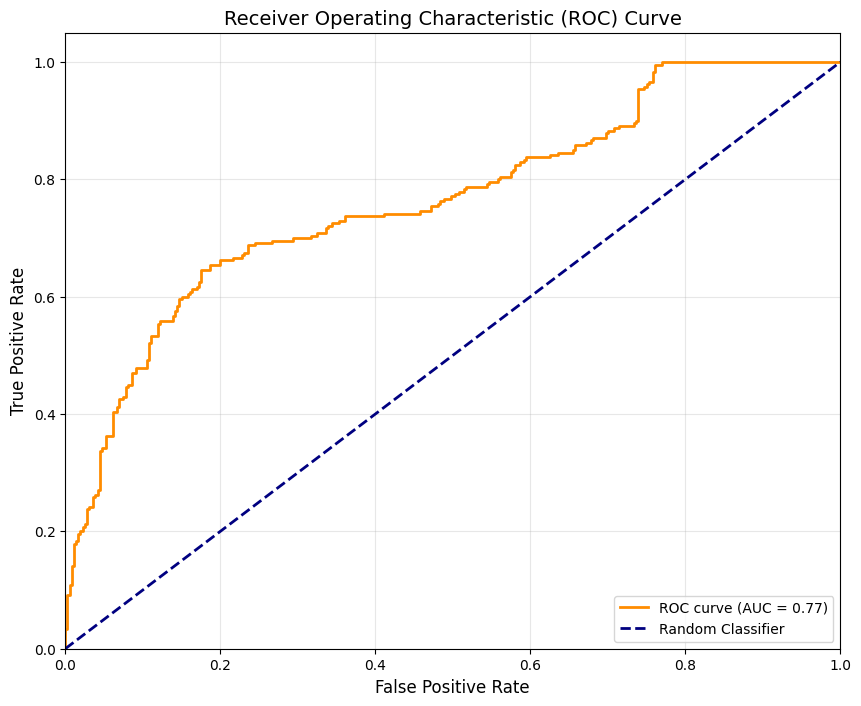


FINAL MODEL PERFORMANCE SUMMARY
Validation Accuracy: 74.67%
Validation Precision: 76.19%
Validation Recall: 53.33%
F1-Score: 62.75%
ROC-AUC Score: 76.56%


In [17]:
# ============================================================================
# CELL 11: ROC Curve and Performance Summary
# ============================================================================
from sklearn.metrics import roc_curve, auc

# Collect all predictions
all_predictions = []
all_labels = []

for images, labels in val_ds:
    preds = model.predict(images, verbose=0)
    all_predictions.extend(preds.flatten())
    all_labels.extend(labels.numpy())

all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)

# ROC Curve
fpr, tpr, thresholds = roc_curve(all_labels, all_predictions)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14)
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

# Print final metrics
print("\n" + "="*50)
print("FINAL MODEL PERFORMANCE SUMMARY")
print("="*50)
print(f"Validation Accuracy: {val_accuracy:.2%}")
print(f"Validation Precision: {val_precision:.2%}")
print(f"Validation Recall: {val_recall:.2%}")
print(f"F1-Score: {2 * (val_precision * val_recall) / (val_precision + val_recall):.2%}")
print(f"ROC-AUC Score: {roc_auc:.2%}")
print("="*50)